<p><b>Titanic Project</b></p>
<p> In this notebook, I have tried to predict the number of people who survived the titanic accident.</p>
<p><b>Overview</b></p>
<p>1) Understand the shape of the data</p>
<p>2) Data Cleaning</p>
<p>3) Exploratory Data Evaluation</p>
<p>4) Normalization</p>
<p>5) Basic Model Building</p>
<p>6) Prediction</p>
<p>7) Evaluation</p>

In [1]:
import numpy as np# linear algebra
import pandas as pd# data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [2]:
training = pd.read_csv('D:/train.csv')#let's load the data
test = pd.read_csv('D:/test.csv')

%matplotlib inline


<p>**Project Planning**</p>
<p> Before Starting any project, I like to outline the steps I take. Below is the rough outline that I created for this </p>
<p>project using commented cells</p>


In [3]:
# Understand nature of the data using .info() , .describe()
# Histograms and Boxplots
# Value Counts 
# Missing Value
# Correlation between the metrics
# Explore interesting ideas
    # Rich survive
    # Age scatterplot with Ticket price
    # Total spent
# feature Engineering
# Preprocessing
# Model
# Prediction
# Refinement and Evaluation 

<p><b>Light Data Exploration</b></p>

 1.<p><b>For numeric data</b></p>
    
    a) Made histograms to understand distributions

    b) Corrplot

    c) Pivot table comparing survival rate across numeric variables

 2.<p><b>For Categorical Data</b></p>

    a) Made bar charts to understand balance of classes
    b) Made Pivot tables to understand relationship with survival

In [3]:
training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
# to better understand the numeric data, we will use .describe() method. This gives us the idea about central tendencies of the data

In [4]:
training.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
# quick way to separate numeric columns
training.describe().columns

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')

In [6]:
# looking at the numeric and categorical variable separately
df_num = training[['Age','SibSp','Parch','Fare']]
df_cat = training[['Survived','Pclass','Sex','Ticket','Cabin','Embarked']]

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


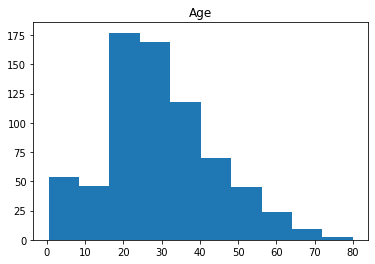

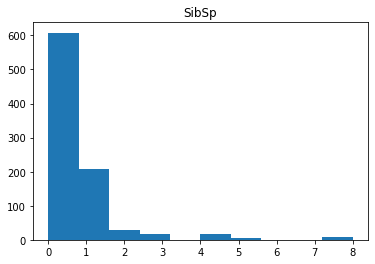

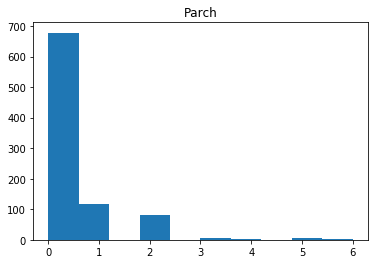

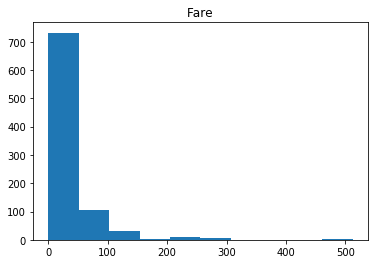

In [7]:
#distribution for all numeric variables
import matplotlib.pyplot as plt
for i in df_num.columns:
    plt.hist(df_num[i])
    plt.title(i)
    plt.show()

Perhaps we should take non normal distributions and consider normalizing them

            Age     SibSp     Parch      Fare
Age    1.000000 -0.308247 -0.189119  0.096067
SibSp -0.308247  1.000000  0.414838  0.159651
Parch -0.189119  0.414838  1.000000  0.216225
Fare   0.096067  0.159651  0.216225  1.000000


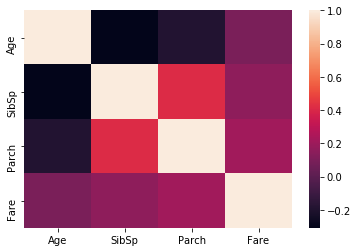

In [10]:
import seaborn as sns
print(df_num.corr())
sns.heatmap(df_num.corr())

In [8]:
# compare survival rate across Age, SibSp, Parch and Fare
pd.pivot_table(training,index = 'Survived', values = ['Age','SibSp','Parch', 'Fare'])

,Age,Fare,Parch,SibSp
Survived,,,,
0,30.626179,22.117887,0.329690,0.553734
1,28.343690,48.395408,0.464912,0.473684


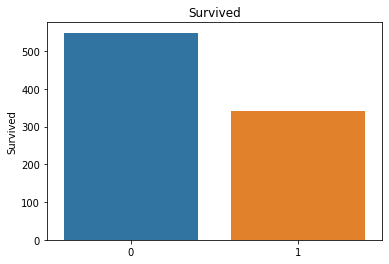

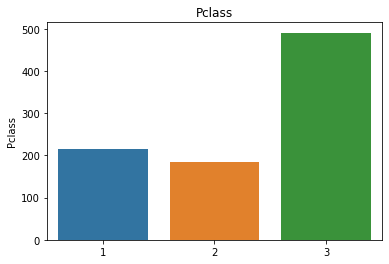

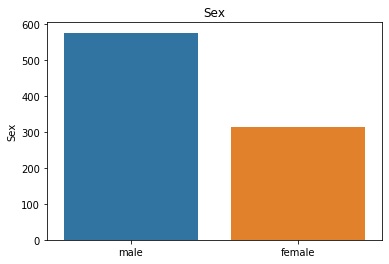

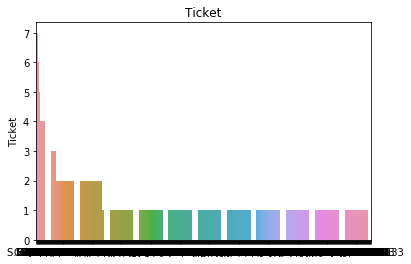

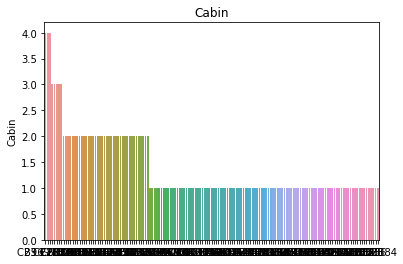

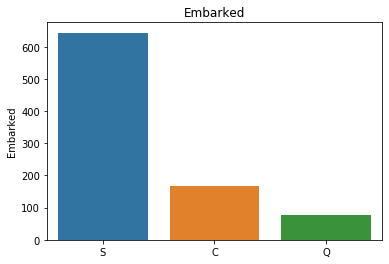

In [11]:
# Checking Categorical Variables
for i in df_cat.columns:
    sns.barplot(df_cat[i].value_counts().index,df_cat[i].value_counts()).set_title(i)
    plt.show()

<p><b>Data Preprocessing For Model</b></p>

<p>1. Fill null values of Embarked Feature with the Mode of it </p>
<p>2. Include only relevant variables (Since we have limited data, I wanted to exclude things like name and passenger ID </p>
<p>so that we have reasonable number of features for our model to deal with. </p>
<p>3.Impute data with mean for Fare and age</p>
<p>4. Normalized Fare from 0 to 1 </p>


In [14]:
training.Age = training.Age.fillna(training.Age.mean())
training.Embarked = training.Embarked.fillna(training.Embarked.value_counts().idxmax())
training.drop('Cabin',axis=1,inplace =True)


In [15]:
training['Fare'] = training['Fare']/training['Fare'].max()

In [16]:
test.Age = test.Age.fillna(test.Age.mean()) # filling nan with mean
test.Fare = test.Fare.fillna(test.Fare.mean())
test.Embarked = test.Embarked.fillna(training.Embarked.value_counts().idxmax()) #filling nan with mode
test.drop('Cabin',axis=1,inplace =True) #dropping this column as it has many nan in it

In [17]:
test['Fare'] = test['Fare']/test['Fare'].max() #normalizing the Fare Column

In [18]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,0.015282,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,0.013663,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,0.018909,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,0.016908,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,0.023984,S


In [19]:
X = training[['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']].values
X[0:5]

array([[3, 'male', 22.0, 1, 0, 0.014151057562208049, 'S'],
       [1, 'female', 38.0, 1, 0, 0.13913573538264068, 'C'],
       [3, 'female', 26.0, 0, 0, 0.015468569817999833, 'S'],
       [1, 'female', 35.0, 1, 0, 0.10364429745562033, 'S'],
       [3, 'male', 35.0, 0, 0, 0.015712553569072387, 'S']], dtype=object)

<p>As we can see some features in this dataset are categorical such as Sex, Embarked. Unfortunately, our models can</p><p>not handle categorical variable. So we will convert these values to numeric one by using pd.get_dummies  

In [20]:
dummy_1 = pd.get_dummies(training['Sex'])
dummy_2 = pd.get_dummies(training['Embarked'])

In [21]:
training = pd.concat([training,dummy_1],axis = 1)
training = pd.concat([training,dummy_2],axis = 1)
training.drop('Sex',axis = 1,inplace = True)
training.drop('Embarked',axis = 1,inplace = True)
training.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,female,male,C,Q,S
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,0.014151,0,1,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,0.139136,1,0,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,0.015469,1,0,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,0.103644,1,0,0,0,1
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,0.015713,0,1,0,0,1


In [22]:
training['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [23]:
X = training[['Pclass','Age','SibSp','Parch','Fare','female','male','C','Q','S']].values
X[0:5]

array([[3.00000000e+00, 2.20000000e+01, 1.00000000e+00, 0.00000000e+00,
        1.41510576e-02, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.00000000e+00],
       [1.00000000e+00, 3.80000000e+01, 1.00000000e+00, 0.00000000e+00,
        1.39135735e-01, 1.00000000e+00, 0.00000000e+00, 1.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [3.00000000e+00, 2.60000000e+01, 0.00000000e+00, 0.00000000e+00,
        1.54685698e-02, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.00000000e+00],
       [1.00000000e+00, 3.50000000e+01, 1.00000000e+00, 0.00000000e+00,
        1.03644297e-01, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.00000000e+00],
       [3.00000000e+00, 3.50000000e+01, 0.00000000e+00, 0.00000000e+00,
        1.57125536e-02, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.00000000e+00]])

In [24]:
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))
X[0:5]

array([[ 0.82737724, -0.5924806 ,  0.43279337, -0.47367361, -0.50244517,
        -0.73769513,  0.73769513, -0.48204268, -0.30756234,  0.61583843],
       [-1.56610693,  0.63878901,  0.43279337, -0.47367361,  0.78684529,
         1.35557354, -1.35557354,  2.0745051 , -0.30756234, -1.62380254],
       [ 0.82737724, -0.2846632 , -0.4745452 , -0.47367361, -0.48885426,
         1.35557354, -1.35557354, -0.48204268, -0.30756234,  0.61583843],
       [-1.56610693,  0.40792596,  0.43279337, -0.47367361,  0.42073024,
         1.35557354, -1.35557354, -0.48204268, -0.30756234,  0.61583843],
       [ 0.82737724,  0.40792596, -0.4745452 , -0.47367361, -0.48633742,
        -0.73769513,  0.73769513, -0.48204268, -0.30756234,  0.61583843]])

In [25]:
Y = training['Survived']
Y[0:5]

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [26]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,0.015282,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,0.013663,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,0.018909,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,0.016908,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,0.023984,S


In [27]:
dummy_3 = pd.get_dummies(test['Sex'])
dummy_4 = pd.get_dummies(test['Embarked'])

In [28]:
test = pd.concat([test,dummy_3],axis = 1)
test = pd.concat([test,dummy_4],axis = 1)
test.drop('Sex',axis = 1,inplace = True)
test.drop('Embarked',axis = 1,inplace = True)
test.head()

,PassengerId,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,female,male,C,Q,S
0,892,3,"Kelly, Mr. James",34.5,0,0,330911,0.015282,0,1,0,1,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",47.0,1,0,363272,0.013663,1,0,0,0,1
2,894,2,"Myles, Mr. Thomas Francis",62.0,0,0,240276,0.018909,0,1,0,1,0
3,895,3,"Wirz, Mr. Albert",27.0,0,0,315154,0.016908,0,1,0,0,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",22.0,1,1,3101298,0.023984,1,0,0,0,1


In [29]:
x = test[['Pclass','Age','SibSp','Parch','Fare','female','male','C','Q','S']].values
x[0:5]

array([[3.00000000e+00, 3.45000000e+01, 0.00000000e+00, 0.00000000e+00,
        1.52815807e-02, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
        1.00000000e+00, 0.00000000e+00],
       [3.00000000e+00, 4.70000000e+01, 1.00000000e+00, 0.00000000e+00,
        1.36630901e-02, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.00000000e+00],
       [2.00000000e+00, 6.20000000e+01, 0.00000000e+00, 0.00000000e+00,
        1.89087407e-02, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
        1.00000000e+00, 0.00000000e+00],
       [3.00000000e+00, 2.70000000e+01, 0.00000000e+00, 0.00000000e+00,
        1.69080739e-02, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.00000000e+00],
       [3.00000000e+00, 2.20000000e+01, 1.00000000e+00, 1.00000000e+00,
        2.39836027e-02, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.00000000e+00]])

In [30]:
x = preprocessing.StandardScaler().fit(x).transform(x.astype(float))
x[0:5]

array([[ 0.87348191,  0.3349926 , -0.49947002, -0.4002477 , -0.49840706,
        -0.75592895,  0.75592895, -0.56814154,  2.84375747, -1.35067551],
       [ 0.87348191,  1.32553003,  0.61699237, -0.4002477 , -0.51327429,
         1.32287566, -1.32287566, -0.56814154, -0.35164743,  0.74037028],
       [-0.31581919,  2.51417495, -0.49947002, -0.4002477 , -0.46508846,
        -0.75592895,  0.75592895, -0.56814154,  2.84375747, -1.35067551],
       [ 0.87348191, -0.25932986, -0.49947002, -0.4002477 , -0.48346631,
        -0.75592895,  0.75592895, -0.56814154, -0.35164743,  0.74037028],
       [ 0.87348191, -0.65554483,  0.61699237,  0.61989583, -0.41847148,
         1.32287566, -1.32287566, -0.56814154, -0.35164743,  0.74037028]])

<hr>

<div id="Modeling">
    <h2>Modeling</h2>
    
</div>

In [31]:
from sklearn.model_selection import KFold
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

In [32]:
clf = KNeighborsClassifier(n_neighbors = 13)
scoring = 'accuracy'
score = cross_val_score(clf, X, Y, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)

[0.84444444 0.83146067 0.80898876 0.82022472 0.83146067 0.79775281
 0.82022472 0.79775281 0.82022472 0.80898876]


In [33]:
# kNN Score
round(np.mean(score)*100, 2)

81.82

In [34]:
dt = DecisionTreeClassifier()
scoring = 'accuracy'
score = cross_val_score(dt, X, Y, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)

[0.74444444 0.79775281 0.78651685 0.7752809  0.80898876 0.78651685
 0.74157303 0.7752809  0.75280899 0.75280899]


In [35]:
# decision tree Score
round(np.mean(score)*100, 2)

77.22

In [36]:
clf = XGBClassifier()
scoring = 'accuracy'
score = cross_val_score(clf, X, Y, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)


[0.83333333 0.83146067 0.76404494 0.79775281 0.86516854 0.84269663
 0.7752809  0.83146067 0.7752809  0.79775281]


In [37]:
round(np.mean(score)*100,2)

81.14

<b><p>Hyperparameter Tuning</p>

In [38]:
#List Hyperparameters that we want to tune.
leaf_size = list(range(1,50))
n_neighbors = list(range(1,30))
p=[1,2]
#Convert to dictionary
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)
#Create new KNN object
knn_2 = KNeighborsClassifier()
#Use GridSearch
clf = GridSearchCV(knn_2, hyperparameters, cv=10)
#Fit the model
best_model = clf.fit(X,Y)
#Print The value of best Hyperparameters
print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])

Best leaf_size: 7
Best p: 1
Best n_neighbors: 14


<b><p> Testing</p>

In [58]:
yhat = best_model.predict(x)